In [8]:
import sys, os
sys.path.insert(0, '../')
sys.path.insert(0, '../python_src/')

import numpy as np
import scipy as sp
import scipy.sparse as sparse
import numpy.random as rand
import numpy.linalg as la
import gzip
import cPickle as pickle
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
%matplotlib inline

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib import collections as mc

import mech_network_solver as mns
import network
import tuning_algs as talgs
import network_plot as nplot

In [87]:
def distortNetworkPos(net, sigma=1.0, seed=None):
    
    rand.seed(seed)
    
    DIM = net.DIM
    NN = net.NN
    node_pos = net.node_pos
    NE = net.NE
    edgei = net.edgei
    edgej = net.edgej
    NGDOF = net.NGDOF
    L = net.L
    
    pert_node_pos = np.zeros(DIM*NN, float)
    for i in range(NN):
        pos = node_pos[DIM*i:DIM*i+DIM]
        pert_node_pos[DIM*i:DIM*i+DIM] = rand.normal(loc=pos, scale=sigma, size=DIM)

        
    bvecij = np.zeros(DIM*NE, float)
    eq_length = np.zeros(NE, float)
    for b in range(NE):
        bvec =  pert_node_pos[DIM*edgej[b]:DIM*edgej[b]+DIM]-pert_node_pos[DIM*edgei[b]:DIM*edgei[b]+DIM]
        bvec -= np.rint(bvec / L) * L
        bvecij[DIM*b:DIM*b+DIM] = bvec
        
        eq_length[b] = la.norm(bvec)
        
        
        

    pert_net = network.Network(DIM, NN, pert_node_pos, NE, edgei, edgej, NGDOF, L)
    
    pert_net.setStretchInt(bvecij, eq_length, np.ones(NE, float) / eq_length)
    
    
    return pert_net

def lower_DZ(net, DZ, seed=None, remove=False):
    
    rand.seed(seed)
    
    DIM = net.DIM
    NN = net.NN
    node_pos = net.node_pos
    NE = net.NE
    edgei = net.edgei
    edgej = net.edgej
    NGDOF = net.NGDOF
    L = net.L
    
    Q = calcEqMat(net)
    
    K = np.ones(NE, float)
    
    H = Q.dot(sparse.diags(K).dot(Q.transpose()))
    
    vals, vecs = sparse.linalg.eigsh(H, k=16, which='SA')
         
    DZ_current = 2.0 * NE / NN - 2.0*DIM + 2.0*NGDOF/NN
            
    print 0, "NE:", NE, "DZ:", DZ_current
        
    edge_list = range(NE)
    rand.shuffle(edge_list)
        
    keep_set = set(range(NE))
        
    i = 0
    while DZ_current > DZ:
        i += 1
        
        if len(edge_list) > 0:
            b_test = edge_list.pop()
        else:
            break
        
        K_test = np.copy(K)
        K_test[b_test] = 0.0
        
        H_test = Q.dot(sparse.diags(K_test).dot(Q.transpose()))
        
        vals, vecs = sparse.linalg.eigsh(H_test, k=16, which='SA')
                
        if vals[NGDOF] < np.sqrt(np.finfo(float).eps):
            continue
        else:
            keep_set.remove(b_test)
            K[b_test] = 0.0
            
            DZ_current = 2.0 * np.sum(K) / NN - 2.0*DIM + 2.0*NGDOF/NN
#             print i, "DZ:", DZ_current        
       
    if remove:
    
        NE = len(keep_set)
        edgei = edgei[list(keep_set)]
        edgej = edgej[list(keep_set)]


        bvecij = np.zeros(DIM*NE, float)
        eq_length = np.zeros(NE, float)
        for b in range(NE):
            bvec =  node_pos[DIM*edgej[b]:DIM*edgej[b]+DIM]-node_pos[DIM*edgei[b]:DIM*edgei[b]+DIM]
            bvec -= np.rint(bvec / L) * L
            bvecij[DIM*b:DIM*b+DIM] = bvec

            eq_length[b] = la.norm(bvec)

        print i, "NE:", NE, "DZ:", DZ_current


        low_net = network.Network(DIM, NN, node_pos, NE, edgei, edgej, NGDOF, L)

        low_net.setStretchInt(bvecij, eq_length, np.ones(NE, float) / eq_length)

        
    else:
        
        bvecij = np.zeros(DIM*NE, float)
        eq_length = np.zeros(NE, float)
        for b in range(NE):
            bvec =  node_pos[DIM*edgej[b]:DIM*edgej[b]+DIM]-node_pos[DIM*edgei[b]:DIM*edgei[b]+DIM]
            bvec -= np.rint(bvec / L) * L
            bvecij[DIM*b:DIM*b+DIM] = bvec

            eq_length[b] = la.norm(bvec)

        print i, "NE:", NE, "DZ:", DZ_current
        
        low_net = network.Network(DIM, NN, node_pos, NE, edgei, edgej, NGDOF, L)
        
        low_net.setStretchInt(bvecij, eq_length, K / eq_length)
        
    return low_net
                
        
def calcEqMat(net):
    node_pos = net.node_pos
    NN = net.NN

    edgei = net.edgei
    edgej = net.edgej
    NE = net.NE
    L = net.L

    DIM = net.DIM

    Q = np.zeros([DIM*NN, NE], float)

    for i in range(NE):
        posi = node_pos[DIM*edgei[i]:DIM*edgei[i]+DIM]
        posj = node_pos[DIM*edgej[i]:DIM*edgej[i]+DIM]
        bvec = posj - posi
        bvec -= np.rint(bvec / L) * L
        bvec /= la.norm(bvec)

        Q[DIM*edgei[i]:DIM*edgei[i]+DIM, i] = -bvec
        Q[DIM*edgej[i]:DIM*edgej[i]+DIM, i] = bvec

    sQ = sparse.csc_matrix(Q)
        
    return sQ

NN 100
NB 300
0 NE: 300 DZ: 2.04
52 NE: 248 DZ: 1.0
0 NE: 248 DZ: 1.0
48 NE: 248 DZ: 0.1


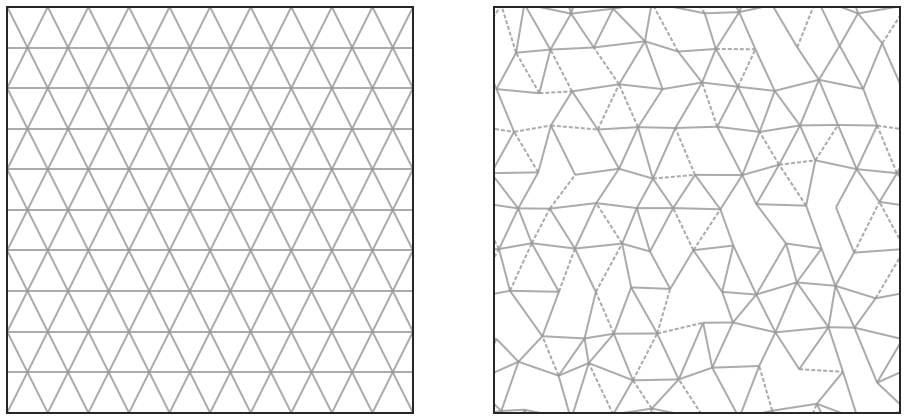

In [92]:
NX = 10
NY = 10
a = 1.0

trinet = network.create2DTriLattice(NX, NY, a)

dist_net = distortNetworkPos(trinet, sigma=0.1, seed=0)

low_net = lower_DZ(dist_net, 1.0, seed=0, remove=True)

net = lower_DZ(low_net, 0.1, seed=0, remove=False)

mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set(color_codes=True)
sns.set_context('poster', font_scale=1.25)
sns.set_palette("Set1", 8)
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})



fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(1, 2, 1, aspect=1.0) 
ax2 = fig.add_subplot(1, 2, 2, aspect=1.0)

nplot.show_network(ax1, trinet)

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])


removed = np.where(net.stretch_mod == 0.0)[0]

styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))


nplot.show_network(ax2, net, styles=styles)

ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])

plt.show()
    